# Not needed anymore.

In [1]:
import sys # for automation and parallelization
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [2]:
import pandas as pd
import geopandas as gpd
from quetzal.model import stepmodel

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


# Preparation of the transport network.
## Initialises a StepModel with parametrised zones.

In [3]:
input_path = '../input/zones/'
output_path = '../output/'
model_path = '../model/'

In [4]:
# Initialising StepModel...
sm = stepmodel.StepModel(debug=False,
                         walk_on_road=False,
                         epsg=4326,
                         coordinates_unit=None)

,index,uuid,sch,nam,gdf,bezeich,geometry,zoneIndex
79,79,DEBE03YY6000000N,110000030308,Blankenfelde,139.0,AX_KommunalesGebiet,"MULTIPOLYGON (((391270.136 5834065.335, 391261...",79
20,20,DEBE09YYO0000001,110000090913,Grünau,9142059.0,AX_KommunalesGebiet,"POLYGON ((403185.443 5809624.113, 403211.440 5...",20
44,44,DEBE09YYO0000003,110000090905,Niederschöneweide,3500763.0,AX_KommunalesGebiet,"POLYGON ((398027.662 5814266.285, 398036.506 5...",44


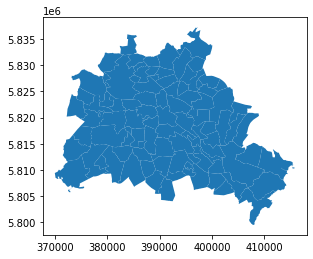

In [6]:
# Adding zones...
zones = gpd.read_file(input_path + "Berliner_Ortsteile.shp")
# remove duplicate zone (Buch)
zones = zones[list(map(lambda x: x not in zones[zones["nam"]=="Buch"][1:].index, zones.index))]
zones = zones.reset_index()
zones["zoneIndex"] = zones.index
zones.plot()
sm.zones = zones 
sm.zones.sample(3)

### Get information for NUTS cells

In [5]:
nuts_to_lau = pd.ExcelFile(input_path + 'NUTS_to_LAU.xls').parse('DE')
nuts_to_lau.columns = ['NUTS_ID', 'lau_id', 'lau_name', 'lau_name_latin', '_', 'population', 'area', 'urbanisation', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
nuts_to_lau = nuts_to_lau[['NUTS_ID', 'lau_id', 'lau_name', 'population', 'area', 'urbanisation']]
nuts_to_lau['lau_short'] = nuts_to_lau['lau_id'].astype(str).str[:-3]

In [6]:
nuts_to_lau.head()

,NUTS_ID,lau_id,lau_name,population,area,urbanisation,lau_short
0,DEF01,1001000,"Flensburg, Stadt",89504,56.73,1,1001
1,DEF02,1002000,"Kiel, Landeshauptstadt",247548,118.65,1,1002
2,DEF03,1003000,"Lübeck, Hansestadt",217198,214.19,1,1003
3,DEF04,1004000,"Neumünster, Stadt",79487,71.66,1,1004
4,DEF05,1051001,Albersdorf,3670,17.12,3,1051


In [7]:
nuts_to_lau_agg = nuts_to_lau[['population', 'area']].groupby(nuts_to_lau['NUTS_ID']).sum()
nuts_to_lau_agg['urbanisation'] = round(nuts_to_lau[['urbanisation']].groupby(nuts_to_lau['NUTS_ID']).mean())
nuts_to_lau_agg['lau_id'] = list(nuts_to_lau.drop_duplicates('NUTS_ID').sort_values(by='NUTS_ID')['lau_short'])

In [8]:
nuts_to_lau_agg.sample(2)

,population,area,urbanisation,lau_id
NUTS_ID,,,,
DE111,634830,207.33,1.0,8111
DE112,391640,617.78,2.0,8115
DE113,533859,641.28,2.0,8116
DE114,257253,642.32,2.0,8117
DE115,543984,686.76,2.0,8118
...,...,...,...,...
DEG0K,80868,1151.33,3.0,16075
DEG0L,98159,845.96,3.0,16076
DEG0M,90118,569.41,3.0,16077


In [9]:
sm.zones.set_index('id', inplace=True)
sm.zones = sm.zones.drop('FID', axis=1)

In [10]:
# Drops all other levels than NUTS 3
sm.zones = pd.merge(sm.zones, nuts_to_lau_agg, left_index=True, right_index=True)

In [11]:
print(sm.zones.shape)
sm.zones.sample(n=5)

(401, 9)


,CNTR_CODE,NUTS_NAME,LEVL_CODE,NUTS_ID,geometry,population,area,urbanisation,lau_id
DE719,DE,Main-Kinzig-Kreis,3,DE719,"POLYGON ((9.47911 50.44069, 9.48148 50.43953, ...",418950,1397.33,2.0,6435
DE232,DE,"Regensburg, Kreisfreie Stadt",3,DE232,"POLYGON ((12.13250 49.06972, 12.13032 49.07454...",152610,80.86,1.0,9362
DE248,DE,Forchheim,3,DE248,"POLYGON ((11.36869 49.66671, 11.35409 49.66471...",116099,642.80,3.0,9474
DE929,DE,Region Hannover,3,DE929,"POLYGON ((9.73462 52.63830, 9.74099 52.63166, ...",1157624,2297.13,2.0,3241
DEG0J,DE,Saale-Holzland-Kreis,3,DEG0J,"POLYGON ((12.02102 50.96912, 12.01916 50.96820...",83051,815.25,3.0,16074


In [12]:
sm.zones['population'].mean()

207030.45635910225

In [13]:
sm.zones['area'].mean()

891.7073815461348

### Add car ownership

Car ownership from the German federal statistical office GENESIS data base table 46251-0006: "Kraftfahrzeugbestand: Kreise, Stichtag, Kraftfahrzeugarten". Download at Nov. 26th 2020. License: Datenlizenz by-2-0; www.govdata.de/dl-de/by-2-0

In [ ]:
cars = pd.read_excel(input_path + 'car_ownership_2017_GENESIS.xls')
cars['sum_MIT'] = cars['Krafträder'] + cars['Pkw']
cars['lau_id'] = cars['lau_id'].astype(str)
cars['sum_MIT'] = cars['sum_MIT'].replace({'--': 0}).astype(int)
cars.set_index('lau_id', drop=True, inplace=True)
lau_car_dict = cars['sum_MIT'].to_dict()
sm.zones['cars'] = sm.zones['lau_id'].map(lau_car_dict)
sm.zones.sample(2)

## Save model

In [14]:
# Saving model zones as geojson
sm.to_json(model_path + 'de_zones', only_attributes=['zones'], encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  9.68it/s]
